## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree


from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.tree import export_text

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

In [28]:
df = pd.read_csv("housing.csv")

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframe into matrices.

In [29]:
df = df.loc[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')].reset_index(drop=True)

In [30]:
# Fill missing values with 0
df.fillna(0,inplace=True)
# Apply the log transform to `median_house_value`.
df['median_house_value'] =  df['median_house_value'].apply(lambda x : np.log1p(x))

In [31]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973866,<1H OCEAN
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287657,<1H OCEAN
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419574,<1H OCEAN
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554971,<1H OCEAN
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287196,<1H OCEAN


In [32]:
#Do train/validation/test split with 60%/20%/20% distribution.
#Use the `train_test_split` function and set the `random_state` parameter to 1.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.copy()
y_val = df_val.median_house_value.copy()
y_test = df_test.median_house_value.copy()

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [33]:
len(df_train.values), len(df_val.values), len(df_test.values)

(9411, 3138, 3138)

In [34]:
# Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.

Which feature is used for splitting the data?

* `ocean_proximity`<--
* `total_rooms`
* `latitude`
* `population`

In [53]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [54]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


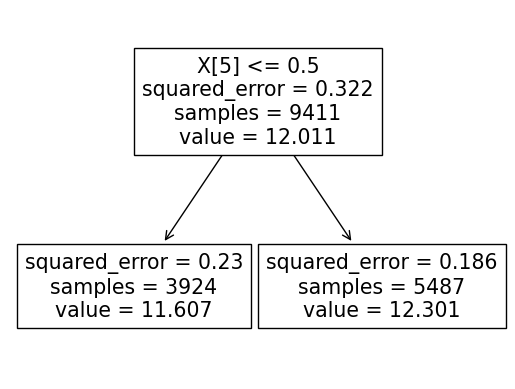

In [60]:
# feature use for splitting data X[5] -> population
print(dt.feature_importances_)
plot_tree(dt);

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on validation?

* 0.045
* 0.245 <-
* 0.545
* 0.845

In [37]:
# Create and train RandomForestRegressor model with specific parameters
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
# Fit model on training data
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [38]:
# Predict:
y_pred = rfr.predict(X_val)

In [39]:
print('%.3f' % mean_squared_error(y_val, y_pred, squared=False))

0.245


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- 160 <-

In [47]:
def get_best_num_estimatots():
    scores = []
    
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        
        scores.append((n, rmse))
        
    df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
    return df_scores

In [62]:
df_scores = get_best_num_estimatots()

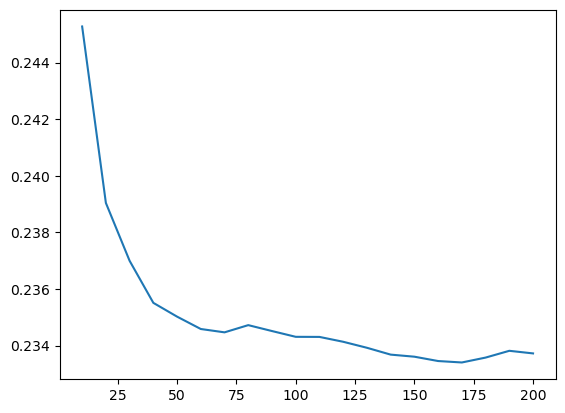

In [50]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [65]:
print(df_scores.round(5))

    n_estimators     rmse
0             10  0.24528
1             20  0.23904
2             30  0.23700
3             40  0.23551
4             50  0.23502
5             60  0.23458
6             70  0.23447
7             80  0.23472
8             90  0.23451
9            100  0.23431
10           110  0.23430
11           120  0.23413
12           130  0.23392
13           140  0.23368
14           150  0.23361
15           160  0.23345
16           170  0.23340
17           180  0.23357
18           190  0.23381
19           200  0.23372


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

What's the best `max_depth`:

* 10 <-
* 15
* 20
* 25

In [79]:
def get_best_num_estimators_and_depth():
    scores = []

    for md in [10, 15, 20, 25]:
        for n in range(10, 201, 10):
            rfr = RandomForestRegressor(n_estimators=n,
                                        max_depth=md,
                                        random_state=1,
                                        n_jobs=-1)
            rfr.fit(X_train, y_train)
    
            y_pred = rfr.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared=False)
    
            scores.append((md, n, rmse))
    
    columns = ['max_depth', 'n_estimators', 'rmse']
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores

In [80]:
df_scores2 = get_best_num_estimators_and_depth()

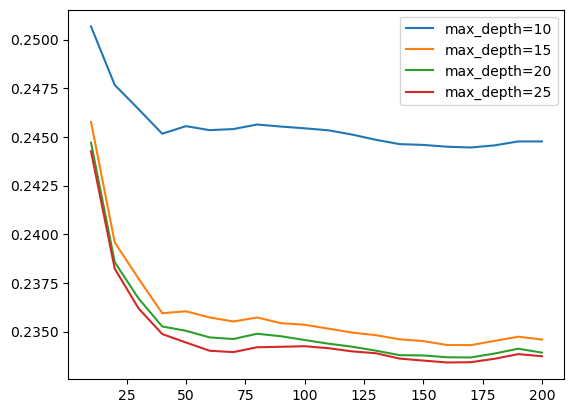

In [81]:
for md in [10, 15, 20, 25]:
    df_subset = df_scores2[df_scores2.max_depth == md]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % md)

plt.legend()

In [82]:
df_scores2.groupby("max_depth")['rmse'].agg(['mean']).reset_index().round(4)#, 'std'

,max_depth,mean
0,10,0.2455
1,15,0.2360
2,20,0.2352
3,25,0.2348


# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

What's the most important feature? 

* `total_rooms`
* `median_income`<-
* `total_bedrooms`
* `longitude`

In [83]:
# Creating a RandomForestRegressor model with specified parameters
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

# Training the RandomForestRegressor model with training data
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [84]:
# Get feature importances from a RandomForestRegressor model
importances = rfr.feature_importances_
# Get the feature names
features = dv.get_feature_names_out()
# Create a DataFrame to store feature importances
feature_importance = pd.DataFrame(importances, index=features)

In [86]:
feature_importance

,0
households,0.015136
housing_median_age,0.030317
latitude,0.102007
longitude,0.086244
median_income,0.335611
ocean_proximity=<1H OCEAN,0.292473
ocean_proximity=INLAND,0.073806
population,0.027136
total_bedrooms,0.015852
total_rooms,0.021417


<AxesSubplot:>

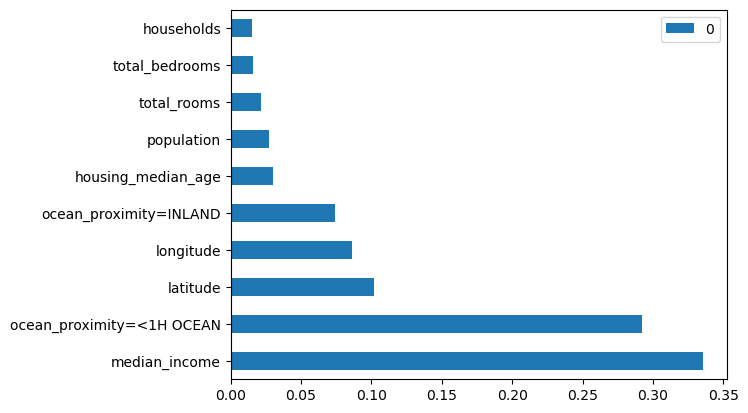

In [87]:
# Sort the DataFrame with feature importances in descending order
sorted_feature_importance = feature_importance.sort_values(by=0, ascending=False)

# Get the most important feature (first row in the DataFrame after sorting)
most_important_feature = sorted_feature_importance.index[0]

# Get the value of the most important feature
most_important_value = sorted_feature_importance.iloc[0, 0]
# Create a horizontal bar plot to visualize feature importances
sorted_feature_importance.plot.barh()

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3 <-
* 0.1
* Both gives same


In [89]:
features = dv.get_feature_names_out()
# have to remove special chars from names else XGboost complains about it
features= [i.replace("=<", "_").replace("=","_") for i in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [103]:
def parse_xgb_output(eta):
    
    features = dv.get_feature_names_out()
    # have to remove special chars from names else XGboost complains about it
    features= [i.replace("=<", "_").replace("=","_") for i in features]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
    
    
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
    
        'objective': 'reg:squarederror',
        'nthread': 8,
    
        'seed': 1,
        'verbosity': 1,
    }
    #watchlist = [(dtrain, 'train'), (dval, 'val')]
    #%%capture output 
    model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    
    y_pred = model.predict(dval)
    
    print('%.3f' % mean_squared_error(y_val, y_pred, squared=False))
    #s = output.stdout
    #return y_pred


In [104]:
parse_xgb_output(eta=0.3)

0.229


In [105]:
parse_xgb_output(eta=0.1)

0.232


## Submit the results

- Submit your results here: TBA
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 23 (Monday), 23:00 CET. After that the form will be closed.